In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [9]:
params = {
    'batch_size': 500,
    'learning_rate': 0.001,
    'epochs': 5,
    'log_interval': 60,
    'momentum': 0.9
}

In [10]:
def load_dataset_and_transform():
    
    transforms_reqd = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    # for multichannel inputs like an RG image, have to provide mean and stddev for each channel to normalize
    loaded_trdata = datasets.MNIST('../data', train=True, download = True, transform = transforms_reqd)
    loaded_tsdata = datasets.MNIST('../data', train=False, transform = transforms_reqd)
    train_loader = torch.utils.data.DataLoader(loaded_trdata, batch_size = params['batch_size'], shuffle = True)
    test_loader = torch.utils.data.DataLoader(loaded_tsdata, batch_size = params['batch_size'], shuffle = False)
    
    # A data loader can be used as an iterator – so to extract the data we can just use the
    #standard Python iterators such as enumerate.                                                                                             
    
    return train_loader, test_loader
    

In [11]:
class ConvNet(nn.Module):
    
    # creating the conv net as :
    # input -> [Conv2d -> ReLU -> Pooling] -> [Conv2d -> ReLU -> Pooling] -> dropout -> fc1 -> fc2 -> output 
    def __init__(self):
        super(ConvNet, self).__init__()
        self.clayer1 = nn.Sequential(\
                                    nn.Conv2d(1, 32, kernel_size=(5,5), stride=1, padding=2),\
                                    nn.ReLU(),\
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        # using a Sequential object to create the [Conv2d -> ReLU -> Pooling] sequence
        self.clayer2 = nn.Sequential(\
                                    nn.Conv2d(32, 64, kernel_size=(5,5), stride=1, padding=2),\
                                    nn.ReLU(),\
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7*7*64, 1000)    
        # 64 output channels with output feature maps of 7*7 => creating a FC layer with 1000 output neurons
        self.fc2 = nn.Linear(1000,10)
        # 10 output neurons for 10 digits of MNIST
        
        
    # the following function describes how a batch of data passes through the network. forward() is described 
    # already in pytorch and is being overridden here
    def forward(self, x):
        out = self.clayer1(x)
        out = self.clayer2(out)
        out = out.reshape(out.size(0), -1)    
        # flattening for further use - out.size() is the shape of one image's output map (7*7*64), and -1 for
        # number of images in the batch - adjusted by pytorch
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
        # no softmax layer defined here as we have used CrossEntropy loss later which incorporates softmax

In [12]:
# creating an instance of convnet created and defining our loss and optimizer
cnet = ConvNet()
print(cnet)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnet.parameters(), lr = params['learning_rate'])

ConvNet(
  (clayer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


In [13]:
train_data, test_data = load_dataset_and_transform()

In [14]:
# training loop - keep storing the loss and accuracy too
losses = []
accs = []
total_imgs_in_dataset = len(train_data.dataset)

for epoch in range(0, params['epochs']):
    for batch_idx, (data, target) in enumerate(train_data):
        
        
        # one forward pass
        model_output = cnet(data)
        #print(model_output)
        train_loss = loss_fn(model_output, target)
        losses.append(train_loss.item())
        
        # backward pass and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # compare predictions
        total_preds = target.size(0)
        _, preds = torch.max(model_output.data, 1) # 1 indicates we need max values for each "row"
        # Returns a namedtuple (values, indices) where values is the 
        # maximum value of each row of the input tensor in the given 
        # dimension dim. And indices is the index location of each maximum value found (argmax).
        matched = (preds==target).sum().item()
        accs.append(matched/total_preds)

        if batch_idx % params['log_interval'] ==0:
            processed_imgs = batch_idx*len(data) # no. of batches * no of images in each batch
            percentage_processed = processed_imgs*100.0/total_imgs_in_dataset
            print('Train Epoch : {} [{}/{}] ({:.0f} %)  Loss: {:.6f}  Train_acc: {:2f}'.format\
                 ((epoch+1), processed_imgs, total_imgs_in_dataset, percentage_processed,\
                 train_loss.item(), (matched/total_preds)*100.0))

Train Epoch : 1 [0/60000] (0 %)  Loss: 2.313188  Train_acc: 9.600000
Train Epoch : 1 [30000/60000] (50 %)  Loss: 0.142383  Train_acc: 95.800000
Train Epoch : 2 [0/60000] (0 %)  Loss: 0.080169  Train_acc: 97.200000
Train Epoch : 2 [30000/60000] (50 %)  Loss: 0.056442  Train_acc: 98.200000
Train Epoch : 3 [0/60000] (0 %)  Loss: 0.035278  Train_acc: 98.600000
Train Epoch : 3 [30000/60000] (50 %)  Loss: 0.062088  Train_acc: 97.800000
Train Epoch : 4 [0/60000] (0 %)  Loss: 0.047022  Train_acc: 97.800000
Train Epoch : 4 [30000/60000] (50 %)  Loss: 0.070167  Train_acc: 98.600000
Train Epoch : 5 [0/60000] (0 %)  Loss: 0.029028  Train_acc: 99.000000
Train Epoch : 5 [30000/60000] (50 %)  Loss: 0.033858  Train_acc: 98.800000


In [18]:
l = list(enumerate(test_data))
print(l[0])

(0, [tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -

In [19]:
#testing loop
correct = 0
total = 0
for data, target in test_data:
        model_output = cnet(data)
        _, preds = torch.max(model_output.data, 1)
        total += target.size(0)
        correct += (preds==target).sum().item()
        
print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
        
        

Test Accuracy of the model on the 10000 test images: 98.77 %


In [20]:
from matplotlib import pyplot as plt

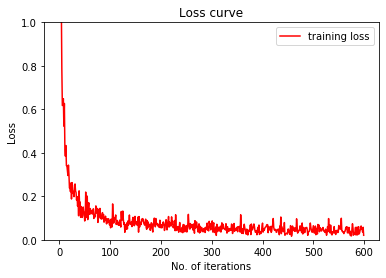

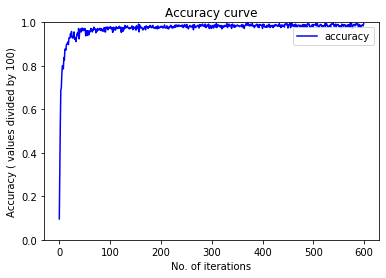

In [29]:
#loss curve (training)
noOfIters = [x for x in range(0,len(losses))]
fig1 = plt.figure()
plt.plot(noOfIters, losses, 'r', label = 'training loss')
plt.title("Loss curve")
plt.legend(loc = 'upper right')
plt.ylim(0, 1)
plt.ylabel('Loss');
plt.xlabel('No. of iterations')
plt.show()
fig1.savefig('loss curve.png')


fig2 = plt.figure()
# accuracy curve (training)
plt.plot(noOfIters, accs, 'b', label = 'accuracy')
plt.title("Accuracy curve")
plt.legend(loc = 'upper right')
plt.ylim(0, 1)
plt.ylabel('Accuracy ( values divided by 100)');
plt.xlabel('No. of iterations')
plt.savefig('accuracy.png')


